In [1]:

using JSON
using Glob
using Dates
using Plots
using ProgressMeter
using DataFrames
using CSV


include("../src/modelHDSparse.jl")
include("../src/encoding.jl")
include("../src/coarseEncoding.jl")


encodeDataset2SparseMat (generic function with 1 method)

## Generate Test Data

In [2]:

struct Data3D
    
    x::Float64
    y::Float64
    z::Float64
    
end

dist3D(pt1::Data3D, pt2::Data3D) = (pt1.x-pt2.x)^2 + (pt1.y-pt2.y)^2 + (pt1.z-pt2.z)^2


nData = 500000
data = [Data3D(0., 0., 0.)]
while length(data) < nData
    x, y, z = 2*rand()-1, 2*rand()-1, 2*rand()-1
    if x^2 + y^2 + z^2 < 1.
        push!(data, Data3D(x, y, z))
    end
end


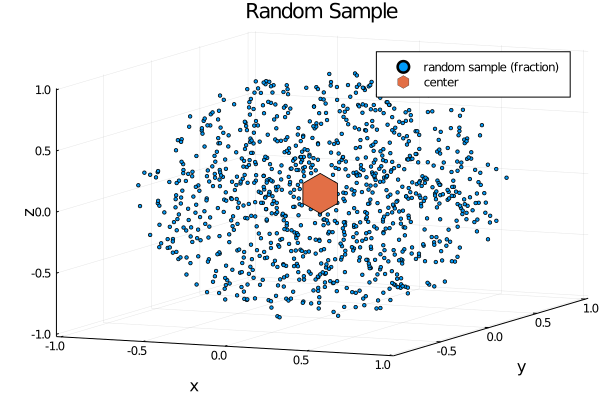

In [3]:

scatter(map(d -> d.x, data[1:1000]),
        map(d -> d.y, data[1:1000]),
        map(d -> d.z, data[1:1000]),
        label="random sample (fraction)", marker=(:circle,2,1.))

scatter!([data[1].x], [data[1].y], [data[1].z],
         label="center", marker=(:hexagon, 20, 1.), 
         xlabel = "x", ylabel="y", zlabel="z", title="Random Sample")


### Specify Coarse Encoding

In [4]:


dimensions = [:x,:y,:z]
nLattices = 1


maximas = Dict(:x => maximum(map(d -> d.x, data)),
               :y => maximum(map(d -> d.y, data)),
               :z => maximum(map(d -> d.z, data)))

minimas = Dict(:x => minimum(map(d -> d.x, data)),
               :y => minimum(map(d -> d.y, data)),
               :z => minimum(map(d -> d.z, data)))

resolution = Dict(:x => 0.3,
                  :y => 0.3, 
                  :z => 0.3)


@time coarseEncoder = CoarseEncoder(dimensions,nLattices,maximas,minimas,resolution)
@time lattice = generateLattice(coarseEncoder);


  0.052227 seconds (50.36 k allocations: 2.405 MiB)
  0.614693 seconds (496.17 k allocations: 24.740 MiB)


### Encode Data

In [9]:

@time sparseHDM = encodeDataset2SparseMat(map(d -> Dict(:x => d.x, :y => d.y, :z => d.z), data), 
                                          coarseEncoder, lattice);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


  4.705705 seconds (17.10 M allocations: 722.515 MiB, 16.28% gc time)


### Compare Searches && Sizes

#### Sizes

In [10]:
println("size of HD data: ", Base.summarysize(sparseHDM))
println("size of 3D data: ", Base.summarysize(data))

size of HD data: 8008168
size of 3D data: 12000040


#### HD Search

In [11]:
hdvec = sparseHDM[1,:]
# time to compute distances
@time [sparseHDM * hdvec for i=1:100];
# time to filter
@time [(res = sparseHDM * hdvec;
        filter(idval -> idval[2] > 2.,  collect(zip(res.nzind, res.nzval)))) for i=1:100];

  1.382207 seconds (376.48 k allocations: 1.136 GiB, 60.63% gc time)
  0.706879 seconds (354.38 k allocations: 1.143 GiB, 30.96% gc time)


#### Cartesian Search

In [12]:
center = data[1]
@time [map(i -> dist3D(center, data[i]), 1:nData) for j=1:100]
@time [filter(i -> dist3D(center, data[i]) < 0.1, 1:nData) for j=1:100];

  5.004273 seconds (100.10 M allocations: 2.614 GiB, 28.78% gc time)
  4.523554 seconds (100.13 M allocations: 2.627 GiB, 24.46% gc time)


## Fuzziness VS Precision

In [19]:

aLattices = [2,2,5,5,20,20,40,40]
aColours = [:blue, :blue, :green, :green, :magenta, :magenta, :red, :red]
reso1 = Dict(:x => 0.2, :y => 0.2, :z => 0.2)
reso2 = Dict(:x => 0.1, :y => 0.1, :z => 0.1)
resolutions = [reso1, reso2, reso1, reso2, reso1, reso2, reso1, reso2]

ps = []
for i = 1:8
    nLattices = aLattices[i]
    colour = aColours[i]
    resolution = resolutions[i]
    
    @time coarseEncoder = CoarseEncoder(dimensions,nLattices,maximas,minimas,resolution)
    @time lattice = generateLattice(coarseEncoder)
    @time sparseHDM = encodeDataset2SparseMat(map(d -> Dict(:x => d.x, :y => d.y, :z => d.z), data),
                                              coarseEncoder, lattice)
    
    hdvec = sparseHDM[1,:]
    res = sparseHDM * hdvec
    distsHD = map(i -> res[i], 1:nData)

    center = data[1]
    dists2D = map(i -> dist3D(center, data[i]), 1:nData)
    
    dd = map(y -> filter(i -> distsHD[i] == y, 1:nData) |>
                (I ->  map(i -> dists2D[i], I)) |>
                    (D -> Dict(:y => y, :max => maximum(D), :min => minimum(D))),
             unique(distsHD))
    x = map(d -> [d[:min], d[:max]], collect(dd))
    y = map(d -> [d[:y], d[:y]], collect(dd)) / nLattices
    
    
    reso = resolution[:x]
    p = plot(x, y, label="", #hcat([["$nLattices"];["" for i in 1:length(y)-1]]...),
             colour=[colour colour],
             xlim=(0., .15),
             title="resol: $reso nLatt: $nLattices",
             xlabel="HD similarity", ylabel="2D distance")
    push!(ps, p)
    
end

  0.000010 seconds (26 allocations: 2.125 KiB)
  0.000067 seconds (83 allocations: 5.266 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  7.949471 seconds (31.71 M allocations: 1.024 GiB, 21.89% gc time)
  0.000008 seconds (26 allocations: 2.125 KiB)
  0.000063 seconds (83 allocations: 5.266 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


  6.929348 seconds (32.51 M allocations: 1.033 GiB, 10.66% gc time)
  0.000008 seconds (26 allocations: 2.125 KiB)
  0.000060 seconds (92 allocations: 5.594 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 13.921413 seconds (71.29 M allocations: 1.965 GiB, 11.25% gc time)
  0.000008 seconds (26 allocations: 2.125 KiB)
  0.000057 seconds (92 allocations: 5.594 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


 14.847534 seconds (73.03 M allocations: 1.968 GiB, 12.33% gc time)
  0.000007 seconds (26 allocations: 2.125 KiB)
  0.000053 seconds (137 allocations: 6.953 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


 47.894697 seconds (269.69 M allocations: 6.271 GiB, 5.36% gc time)
  0.000007 seconds (26 allocations: 2.125 KiB)
  0.000055 seconds (137 allocations: 6.953 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


 47.810594 seconds (275.59 M allocations: 6.409 GiB, 5.51% gc time)
  0.000007 seconds (26 allocations: 2.125 KiB)
  0.000048 seconds (197 allocations: 8.828 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


 92.679634 seconds (534.22 M allocations: 12.127 GiB, 5.18% gc time)
  0.000008 seconds (26 allocations: 2.125 KiB)
  0.000059 seconds (197 allocations: 8.828 KiB)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


 93.511232 seconds (545.68 M allocations: 12.304 GiB, 4.11% gc time)


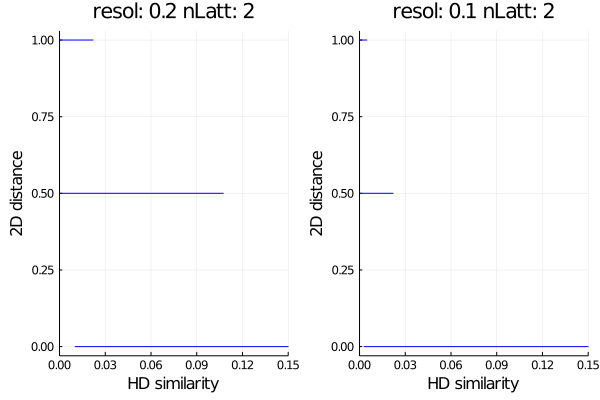

In [20]:
plot(ps[1], ps[2])

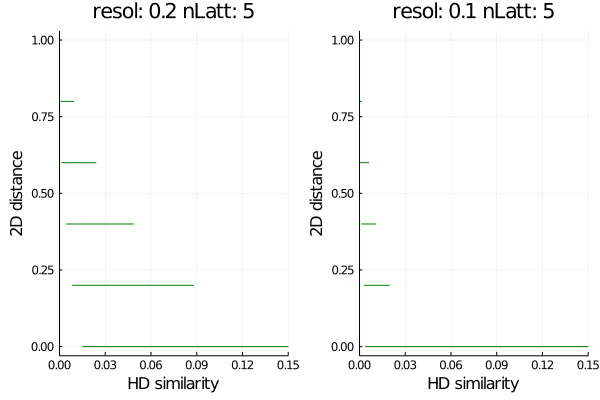

In [21]:
plot(ps[3], ps[4])

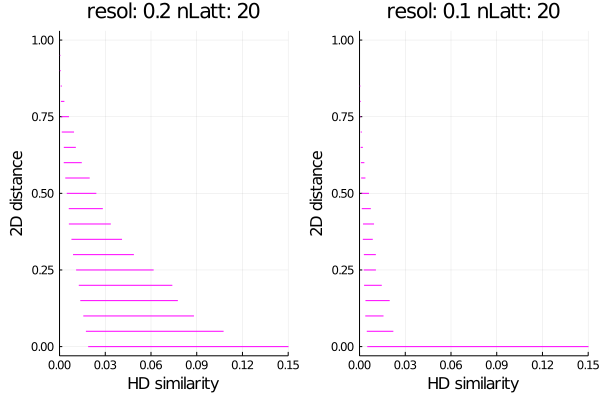

In [22]:
plot(ps[5], ps[6])

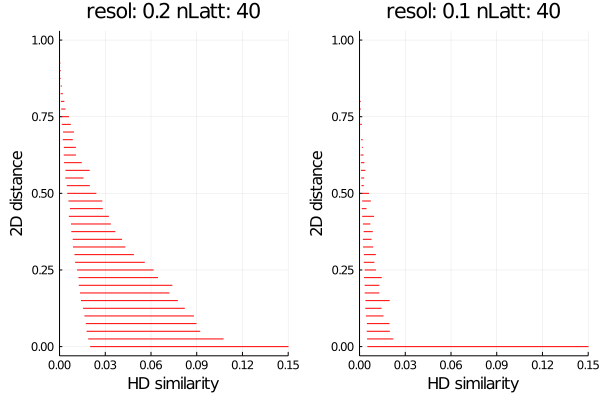

In [23]:
plot(ps[7], ps[8])